# Problem set 1 (100 pts)

## Important information

* Read [homework rules](../hw.pdf) carefully. <font color='red'>If you do not follow it you will likely be penalized.</font>


* We provide signatures of the functions for every coding task. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

## Problem 0 (Piazza) Your solution will not be graded unless this problem is solved!

You were invited to Piazza, where you can find [announcement](https://piazza.com/class/j9cp73agv3u3w4?cid=7) on the course project. In case you didn't get an invitation to your @skoltech.ru email from Piazza, ask TA to set you up there. 
* Register in Piazza with your @skoltech.ru email.
* Write a private post to TAs in Piazza describing your favorite math fact (not necessarily a difficult one).

In [1]:
#Done!

## Problem 1 (Python demo) 40 pts
### Data preparation (10 pts)

* First of all download $\verb|.wav|$ file with starcraft sound from [here](TMaRdy00.wav). Load it in python and play using the following functions:

In [2]:
from scipy.linalg import toeplitz
import numpy as np
import math
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib notebook

<IPython.core.display.Javascript object>


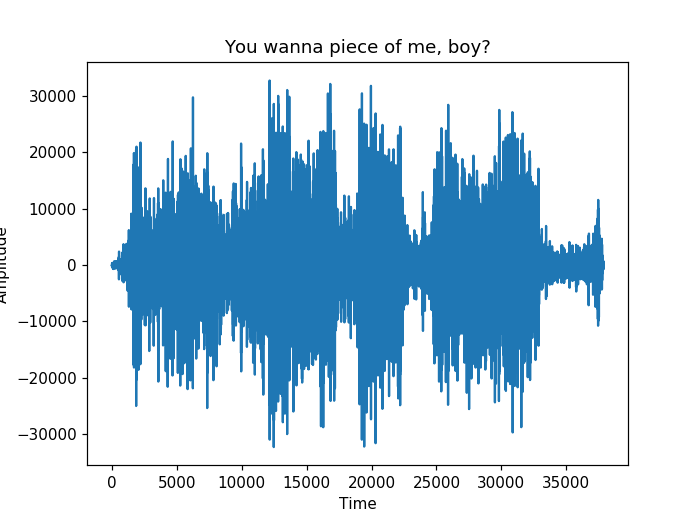

In [3]:
# reading
rate, audio = wav.read("TMaRdy00.wav")

# plotting
plt.plot(audio)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("You wanna piece of me, boy?")
plt.show()

# playing
Audio(audio, rate=rate)

Our next goal is to process this signal by multiplying it by a special type of matrix (convolution operation) that will smooth the signal. 

* Before processing this file let us estimate what size of matrix we can afford. Let $N$ be the size of the signal. Estimate analytically memory in megabytes required to store dense square matrix of size $N\times N$ to fit in your operation memory and print this number. Cut the signal so that you will not have swap (overflow of the operation memory). **Note:** Cut the signal by taking every p-th number in array: ```signal[::p]```. 

In [4]:
signal = audio[::2]
N = len(signal)
print(N)

18944


* Write a function 
```python
def gen_toeplitz(N, alpha):    
    return T
```
that outputs matrix $T$: $$T_{ij} = \sqrt{\frac{\alpha}{\pi}}e^{-\alpha (i-j)^2}, \quad i,j=1,\dots,N$$ as numpy array. <font color='red'> Avoid using loops or lists! </font> The function [np.meshgrid](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html) will be helpful for this task.
**Note:** matrices that depend only on difference of indices: $T_{ij} \equiv T_{i-j}$ are called **Toeplitz**. Toeplitz matrix-by-vector multiplication is **convolution** since it can be written as $$y_i = \sum_{j=1}^N T_{i-j} x_j.$$ Convolutions can be computed faster than $\mathcal{O}(N^2)$ complexity using Fast Fourier transform (will be covered later in our course, no need to implement it here).

In [5]:
# INPUT: N - integer (positive), alpha - float (positive)
# OUTPUT: T - np.array (shape: NxN)

def gen_toeplitz(N, alpha): # 5 pts
    
    # Write your code here
    xx, yy = np.meshgrid(np.arange(1,N+1),np.arange(1,N+1))
    T = np.sqrt(alpha/np.pi)*np.exp(-alpha*(xx-yy)**2)
    return T


### Convolution (10 pts)

* Write a function ```convolution``` (see below)
that takes the signal you want to convolve and multiply it by Toeplitz matrix $T$ (for matvec operations use @ symbol). Plot the first $100$ points of the result and the first $100$ points of your signal on the same figure. Do the same plots for $\alpha = \frac{1}{5}$, $\alpha = \frac{1}{100}$ using ```plt.subplots``` in matplotlib. Each subplot should contain first $100$ points of initial and convolved signals for some $\alpha$. Make sure that you got results that look like smoothed initial signal.

In [6]:
# INPUT: signal - np.array (shape: Nx1), N - int (positive), alpha - float (positive)
# OUTPUT: convolved_signal - np.array (shape: Nx1)

def convolution(signal, N, alpha): # 4 pts
    T = gen_toeplitz(N, alpha)
    # Write your code here   
    return T.dot(signal)


* Play the resulting signal. In order to do so you should also scale the frequency (rate), which is one of the inputs in `Audio`.  
Note that you cannot play a signal which is too small.

<IPython.core.display.Javascript object>


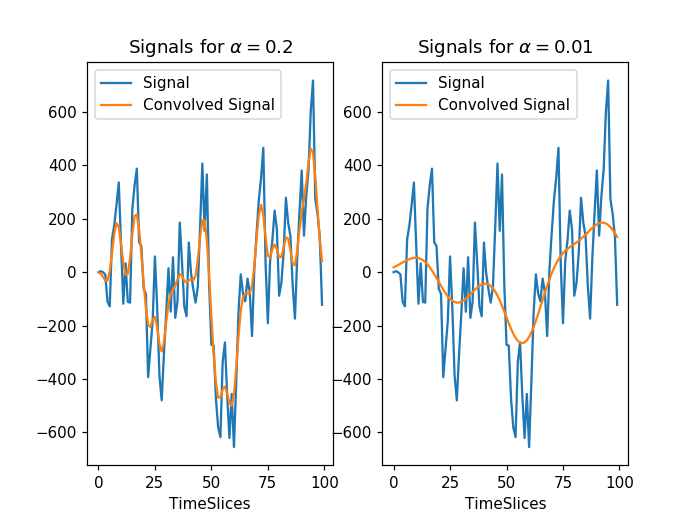

Text(0.5,1,'Signals for $\\alpha=0.01$')

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2)

signal1Plot, = ax1.plot(np.arange(100), signal[:100])
signal1ConvolvedPlot, = ax1.plot(np.arange(100), convolution(signal[:100],100,0.2))
ax1.set_title(r"Signals for $\alpha=0.2$")
ax1.set_xlabel("TimeSlices")
ax1.legend([signal1Plot, signal1ConvolvedPlot], ['Signal', 'Convolved Signal'])

ax2.plot(np.arange(100), signal[:100])
ax2.plot(np.arange(100), convolution(signal[:100],100,0.01))
ax2.set_xlabel("TimeSlices")
ax2.legend([signal1Plot, signal1ConvolvedPlot], ['Signal', 'Convolved Signal'])
ax2.set_title(r"Signals for $\alpha=0.01$")


### Deconvolution (20 pts)

Given a convolved signal $y$ and an initial signal $x$ our goal now is to recover $x$ by solving the system
$$
    y = Tx.
$$
To do so we will run iterative process
$$
    x_{k+1} = x_{k} - \tau_k (Tx_k - y), \quad k=1,2,\dots
$$
starting from zero vector $x_0$. There are different ways how to define parameters $\tau_k$.
Different choices lead to different methods (e.g. Richardson iteration, Chebyshev iteration, etc.).
This topic will be covered in details later in our course.

To get some intuition why this process converges to the solution of $Tx=y$, we can consider the following. Let us note that if $x_k$ converges to some limit $x$, then so does $x_{k+1}$. Taking $k\to \infty$ we arrive at $x = x - \tau (Tx -  y)$ and hence $x$ is the solution of $Tx = y$. 

Another important point is that iterative process requires only matrix-vector porducts $Tx_k$ on each iteration instead of the whole matrix. In this problem we, however, work with the full matrix, but keep in mind, that convolution can be done efficiently without storing the whole matrix.

* For each $k$ choose paremeter $\tau_k$ such that the residual $r_{k+1}=Tx_{k+1} - y$ is minimal possible (*line search* with search direction $r_k$):
$$
    \|Tx_{k+1} - y\|_2 \to \min_{\tau_k}
$$
found analytically. The answer to this bullet is a derivation of $\tau_k$. The parameter $\tau_k$ should be expressed in terms of residuals $r_k = T x_k - y$.

### Solution
One can represent $r_k$ as $r_k=Tx_k-y=Tx_{k-1}-\tau T(Tx_{k-1}-y)-y=r_{k-1}-\tau Tr_{k-1}$. We need to find $\tau$ for which
$$ \Vert r_{k-1}-\tau T r_{k-1} \Vert \rightarrow \text{min}.$$
Since the norm is euclidean 2-norm, $\Vert r_k \Vert=\sqrt{(r_k,r_k)}$. Square root is monotonically increasing function, so it is enough to minimize $(r_k,r_k)=(r_{k-1}-\tau T r_{k-1},r_{k-1}-\tau T r_{k-1})$, where $r_{k-1}$ is known and $T$ is our convolution matrix. This is a problem of finding best approximation of $r_{k-1}$ using $Tr_{k-1}$ in Hilbert space, hence
$$ (r_{k-1}-\tau Tr_{k-1},Tr_{k-1})=0. $$
Consequently,
$$ \tau_k = \frac{(r_{k-1},Tr_{k-1})}{\Vert Tr_{k-1}\Vert^2}. $$

* Write a function ```iterative```
that outputs accuracy –– a numpy array of relative errors $\big\{\frac{\|x_{k+1} - x\|_2}{\|x\|_2}\big\}$ after ```num_iter``` iterations using $\tau_k$ from the previous task. Set ```num_iter=1000```, ```x=s[::20]``` and do a convergence plot for $\alpha = \frac{1}{2}$ and $\alpha = \frac{1}{5}$. **Note:** The only loop you are allowed to use here is a loop for $k$.

In [8]:
# INPUT:  N - int (positive), alpha - float (positive), num_iter - integer (positive), 
#y - np.array (shape: Nx1, convolved signal), s - np.array (shape: Nx1, original signal)
# OUTPUT: rel_error - np.array size (num_iter x 1)

def iterative(N, num_iter, y, s, alpha): # 10 pts
    # Write your code here
    xk=np.zeros(N)
    k=0
    rel_error = np.zeros(num_iter)
    while(k<num_iter):
        rk=convolution(xk,len(xk),alpha)-y
        Trk=convolution(rk,len(rk),alpha)
        xk= xk - np.dot(rk,Trk)/np.dot(Trk,Trk)*rk
        rel_error[k]=np.linalg.norm(xk-s,2)/np.linalg.norm(s,2)
        k=k+1
        
    return rel_error


In [9]:
x=signal[::20]
rel_errs1=iterative(len(x),1000,convolution(x,len(x),0.5),x,0.5)
rel_errs2=iterative(len(x),1000,convolution(x,len(x),0.2),x,0.2)

<IPython.core.display.Javascript object>


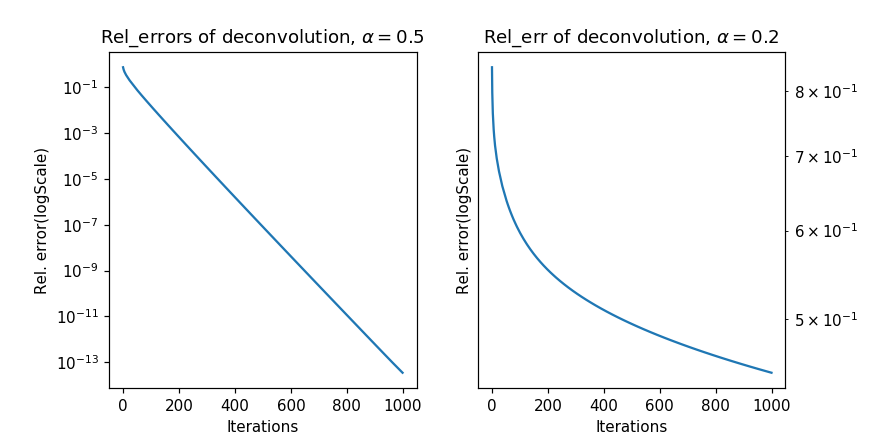

Text(0.5,1,'Rel_err of deconvolution, $\\alpha=0.2$')

In [10]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.plot(rel_errs1)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Rel. error(logScale)')
ax1.set_yscale('log')
ax1.set_title(r'Rel_errors of deconvolution, $\alpha=0.5$')

ax2.plot(rel_errs2)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Rel. error(logScale)')
ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.set_title(r'Rel_err of deconvolution, $\alpha=0.2$')

* Set ```x=s[::20]```, ```num_iter=1000``` and $\alpha=\frac{1}{5}$. Explain what happens with the convergence if you add small random noise of amplitude $10^{-3}\max(x)$  to $y$. The answer to this question should be an explanation supported by plots and/or tables.

In [41]:
x=signal[::20]
y=convolution(x,len(x),0.2)
noisedY=y+np.random.uniform(-np.max(x)*1e-3,np.max(x)*1e-3,len(x))
rel_errsNoised=iterative(len(x),1000,noisedY,x,0.2)

Text(0.5,1,'Rel_errors of deconvolution, $\\alpha=0.2$')

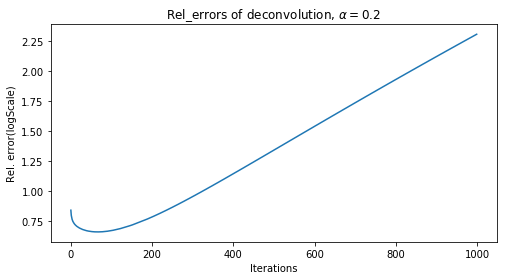

In [51]:
(f, ax) = plt.subplots(figsize=(8,4))

ax.plot(rel_errsNoised)
ax.set_xlabel('Iterations')
ax.set_ylabel('Rel. error(logScale)')
#ax.set_yscale('log')
ax.set_title(r'Rel_errors of deconvolution, $\alpha=0.2$')

In [37]:
print(np.linalg.cond(gen_toeplitz(len(x),0.2),2))
print(np.max(x)*1e-3)

113950.211418
30.473


Looks like the method diverges most of the times. Occassionally I have got the convergence case, but, unfortunately, have not saved this. For this case here is a short explanantion about large relative error. 

Since the solution to deconvolution problem is unique, we changed the solution by adding perturbations to the right part. We can estimate relative error of exact solution:

$$
\frac{\Vert \delta x \Vert}{\Vert x \Vert} \leq \text{cond}(T) \frac{\Vert \delta y \Vert}{\Vert y \Vert},
$$

where $\Vert \delta y \Vert \leq max(x)10^{-3} \approx 30.473$ are random perturbations, $\text{cond}(T)\approx 113950.2114$ is condition number of convolution matrix, $x$ is the true solution, and $\Vert \delta x \Vert / \Vert x \Vert$ is the relative error arising from noise. Therefore, we can estimate the relative error of deconvolution with this expression:

In [38]:
print(np.linalg.cond(gen_toeplitz(len(x),0.2),2)*np.max(x)*1e-3/np.linalg.norm(y,2))

43.8407817978


## Problem 2 (Theoretical tasks)  30 pts


_1._ (5 pts) Prove that $\|Ux\|_2 = \|x\|_2$ for any $x\in\mathbb{C}^n$ iff $U$ is unitary.
  
  
_2._ (5 pts) Prove that an operator norm is a matrix norm, i.e. it is a norm on the vector space of matrices and satisfies the submultiplicative property.


_3._ (5 pts) Prove that $\|A\|_2 = \sigma_1(A)$ and $\|A\|_F = \sqrt{\sigma_1^2(A) + \dots + \sigma_r^2(A)}$ using unitary invariance of $\|\cdot\|_2$ and $\|\cdot\|_F$.


_4._ (5 pts) Prove that $\|AB\|_F \leq \|A\|_2 \|B\|_F \leq \|A\|_F \|B\|_F$.


_5._ (5 pts) Find a gradient of the generalized Rayleigh quotient $R(x) = \dfrac{(x, Ax)}{(x, Bx)}$, $A=A^*$, $B>0$. How is zero gradient condition connected to the classical eigenvalue problem if $B=I$, where $I$ is the identity matrix.

_6._ (5 pts) Alternating optimization in the task of approximation of a matrix $A\in\mathbb{R}^{n\times m}$ with its rank-$r$ approximation $A_r \equiv UV^\top$, $U\in\mathbb{R}^{n\times r}$, $V\in\mathbb{R}^{m\times r}$ can be formulated as sequential minimization by $U$ and by $V$ of the functional $F(U,V)$: 

$$
    F(U,V) = \frac 12 \|A - UV^\top\|_F^2 + \frac{\lambda_U}2 \|U\|_F^2 + \frac{\lambda_V}2 \|V\|_F^2,
$$

where $\lambda_U,\lambda_V$ are regularization constants. 
Find gradient of $F(U,V)$ w.r.t. $U$ and $V$.

### 1
$\Vert Ux \Vert_2 = \sqrt{(Ux,Ux)} = \sqrt{(U^*Ux,x)}=\sqrt{(x,x)}=\Vert x \Vert_2$

### 2

Define operator norm of $A$ as
$$
\Vert A \Vert = \text{sup}_{x \neq 0}\frac{\Vert Ax \Vert}{\Vert x \Vert}.
$$
From this definition one can conclude that $\Vert Bx \Vert \leq \Vert B \Vert \Vert x \Vert$ for any non-zero $x$, hence,
$$
\Vert x\Vert \geq \frac{\Vert Bx\Vert}{\Vert B\Vert}
$$
cosidering $\Vert B \Vert \neq 0$ w.l.o.g. (otherwise the inequality is obvious).

Now use this and apply the definition to composition of operators $AB$:
$$
\Vert AB \Vert = \text{sup}_{x \neq 0} \frac{\Vert ABx \Vert}{\Vert x\Vert} \leq \Vert B \Vert \text{sup}_{x \neq 0} \frac{\Vert ABx\Vert}{\Vert Bx\Vert} \leq \Vert A\Vert \Vert B \Vert.
$$

### 3

First do SVD decomposition $A=U\Sigma V^*$. By definition of operator norm,
$$
\Vert A \Vert = \text{sup}_{x \neq 0}\frac{\Vert Ax\Vert}{\Vert x \Vert}.
$$

Consider firstly the case $\Vert \cdot \Vert=\Vert \cdot \Vert_2$. Using unitary property of $U$ we can claim
$$
\text{sup}_{x \neq 0}\frac{\Vert Ax\Vert}{\Vert x \Vert} = \text{sup}_{x \neq 0}\frac{\Vert \Sigma V^*x \Vert}{\Vert x \Vert}.
$$
One can change the variables $V^*x=y$, since $V^*$ is non-degenerate, supremum will not change. Using unitary property of $V$ implies
$$
\text{sup}_{x \neq 0}\frac{\Vert \Sigma y \Vert}{\Vert Vy \Vert}=\text{sup}_{x \neq 0}\frac{\Vert \Sigma y \Vert}{\Vert y \Vert} \leq \sqrt{\sigma_1(A)},
$$
where $\sigma_1$ is the largest (by absolute value) singular value of $A$. There is $y=[1,0...,0]^T$ on which this value is obtained, hence,
$$
\Vert A \Vert_2 = \sigma_1(A).
$$

Let $\Vert \cdot \Vert=\Vert \cdot \Vert_F$, $\Sigma V^* = P$ and $P_i$ are the columns of matrix $P$.
$$
\Vert A \Vert^2= \Vert U P \Vert^2= \sum_{i=1}^{n}\Vert UP_i\Vert^2 = \sum_{i=1}^{n}\Vert P_i\Vert^2 = \Vert P\Vert^2
$$
by unitary property of $U$. Let $e_i$ denote the standard $n$-dimensional basis, then by unitary property of $V^*$
$$
\Vert P \Vert ^2 = \sum_{i=1}^{n}\Vert\sigma_iV^*e_i\Vert^2 = \sum_{i=1}^{n}\vert\sigma_i\vert^2
$$

### 4

Let $B_i$ be the columns of matrix $B$.
$$
\Vert AB\Vert^2_F = \sum_{i=1}^{n}\Vert AB_i\Vert^2_2 \leq \Vert A \Vert^2_2 \sum_{i=1}^n \Vert B_i\Vert_2^2= \Vert A \Vert_2^2 \Vert B \Vert_F^2.
$$
With the previous excercise,
$$
\Vert A \Vert_2^2 \Vert B \Vert_F^2 \leq \Vert A \Vert_F^2 \Vert B \Vert_F^2.
$$
This inequality also implies
$$
\Vert A \Vert_2 \Vert B \Vert_F \leq \Vert A \Vert_F \Vert B \Vert_F,
$$
since square root is a monotonically increasing function.

### 5

Denote $F(x)=(x,Ax)$ and $G(x)=(x,Bx)$. To obtain a gradient, we need to calculate partial derivatives
$$
\frac{\partial R}{\partial x_i}=\frac{\frac{\partial F}{\partial x_i}G(x)-\frac{\partial G}{\partial x_i}F(x)}{G(x)^2}.
$$
Hence, the gradient
$$
\nabla R(x) = \frac{\nabla F G(x)-\nabla G F(x)}{G(x)^2},
$$
where $\nabla F = 2Ax$ and $\nabla G = (B+B^T)x$. Write down the zero condition for gradient $\nabla R = 0$ considering $B=I$:
$$
    (x,x)\nabla F-2xF(x)=0
$$
$$
    Ax = \frac{2(Ax,x)}{(x,x)}x.
$$
If $x$ is an eigenvector of $A$ with eigenvalue  $2\lambda$, then
$$
Ax=0.5\lambda x,
$$
and multiplying (in the sense of scalar product) by $x$ gives
$$
(Ax,x)=0.5\vert \lambda \vert (x,x). 
$$
It implies that
$$
\vert \lambda \vert = \frac{2(Ax,x)}{(x,x)}.
$$
Hence, if x is the solution of $\nabla R(x) =0$, then it is an eigenvector of $A$ with eigenvalue $0.5\lambda$.

### 6

$$
    F(U,V) = \frac 12 \|A - UV^\top\|_F^2 + \frac{\lambda_U}2 \|U\|_F^2 + \frac{\lambda_V}2 \|V\|_F^2.
$$

We can compute two parts of the gradient: $\nabla_U F$ and $\nabla_V F$. Using the chain rule gives
$$
\nabla_UF=-(A-UV^T)V^T+\lambda_UU.
$$
Similarily,
$$
\nabla_VF=-(A-UV^T)U(\nabla V^T)+\lambda_V V = -(A-UV^T)U\text{diag}(V),
$$
where $diag(V)$ is a matrix of zeros except the diagonal which is equal to the diagonal of $V$.

## Problem 3 (Strassen algorithm) 10 pts

1. What is the exact complexity of naive matrix-matrix multiplication? What is the complexity of Strassen algorithm? Can complexity of matrix-matrix multiplication be asymptotically smaller than $\mathcal{O}(n^2)$? Why?

2. It's a good idea not to do recursion to the bottom level in the Strassen algorithm. Let us check if only several   levels of the recursion help to reduce the constant outside $n^3$. Find analytically constant outside $n^3$ after $3$ levels of recursion in the Strassen algorithm. Compare it with the constant in the naive multiplication. **Note:** Assume that additions and multiplications in computer have the same computational cost.

## Problem 4 (SVD)  20 pts

In [43]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import scipy as sp
import scipy.ndimage

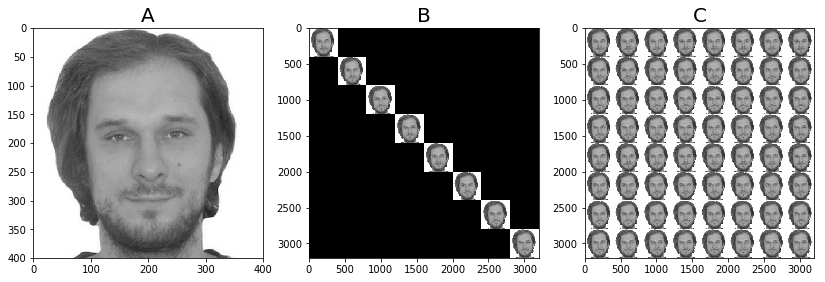

In [99]:
img = np.array(Image.open('ivan.png'), dtype=np.float64)
img_block = np.array(Image.open('ivan_block.png'), dtype=np.float64)
img_diag_block = np.array(Image.open('ivan_diag_block.png'), dtype=np.float64)
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('A', fontsize=20)
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(132)
plt.title('B', fontsize=20)
plt.imshow(img_diag_block, cmap=plt.cm.gray)
plt.subplot(133)
plt.title('C', fontsize=20)
plt.imshow(img_block, cmap=plt.cm.gray)
plt.show()

### Part A (10 pts)

1. Obtain the singular values of Ivan image **A** using `np.linalg.svd` and plot them. Do not forget to use logarithmic scale.

2. Why is the exact rank of **A** is not equal to the size of the figure?

3. Create a function ```approximate``` that takes an image matrix $M$ and a relative accuracy $\epsilon$ as an input and returns an approximated image matrix $M_\epsilon$ such that $\|M - M_\epsilon\|_F / \|M\|_F \leq \epsilon$, and   rank$(M_\epsilon)$. See how the function ```approximate``` must look like below.

4. Plot $M_\epsilon$ (for image **A**). Estimate for which accuracy value $\epsilon$ image $M_\epsilon$ begins to "look like" $M$. Note that, eventually, pixel-wise proximity is not a good metric for image similarity when doing low-rank approximation.

5. Plot $M_\epsilon$ (for image **A**) such that $rank(M_\epsilon) = 5, 20, 50$ using ```plt.subplots```. Note that for even relatively small ranks  image is well-recognizable.

Text(0,0.5,'$\\sigma_k(A)$')

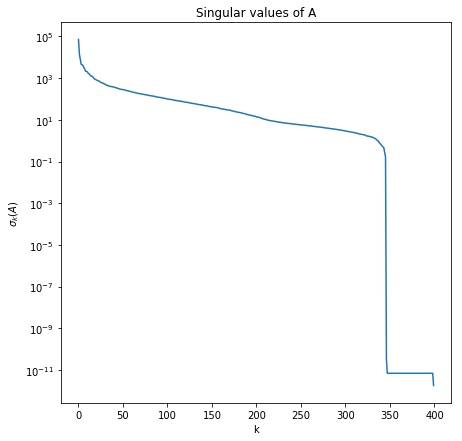

In [60]:
U, s, V = np.linalg.svd(img)

f, ax = plt.subplots(figsize=(7,7))

ax.plot(s)
ax.set_title('Singular values of A')
ax.set_xlabel('k')
ax.set_yscale('log')
ax.set_ylabel(r'$\sigma_k(A)$')


It is normal that the exact rank is lesl than the size of image: even visually there are two packs of purely white columns on the left and right sides.

According to Eckart-Young theorem (see [lecture](https://github.com/oseledets/nla2017/blob/master/lectures/lecture-4.ipynb)), the solution to best approximation problem with fixed rank $k$ is given by the SVD of A with replaced $\Sigma \rightarrow \tilde{\Sigma}$, where $\tilde{\Sigma}$ is a diagonal matrix with $k$ largest singular values and $n-k$ zeros.

We can construct the following algorithm. For all $k=n,n-1,...$ Find $M_\epsilon$ of rank $k$ until the relative error $\Vert M-M_\epsilon \Vert_F/\Vert M \Vert_F > \epsilon$. The last $k$ and $M_\epsilon$ with valid relative error is the needed answer.

By excercise 3 from problem 2, we can easily compute the Frobenius's norm on each step:
$$
\Vert U(\Sigma-\tilde{\Sigma})V^*\Vert_F=\Vert\Sigma-\tilde{\Sigma}\Vert_F=\sqrt{\sum_{i=k+1}^n\sigma_i^2(A)}.
$$

After some experiments I have found $\epsilon$ such that for all smaller epsilon the image is relatively recognizable.

In [176]:
def approximate(img, eps): # 5 pts out of 10 pts
    
    eps_rank = img.shape[0]

    (U,s,V)=np.linalg.svd(img)
    abs_err=0
    normM=np.linalg.norm(img,'fro')
    while(np.sqrt(abs_err)/normM<=eps):
        eps_rank=eps_rank-1
        abs_err=abs_err + s[eps_rank]**2
    
    eps_rank=eps_rank+1 #the best approximation was before the exit condition is broken
    s[eps_rank:]=0
    # your code here
    return np.dot(U,np.multiply(s[:,None], V)), eps_rank #



In [218]:
eps=0.7e-1
(img_appr,rank) = approximate(img,eps)
print(rank)


11


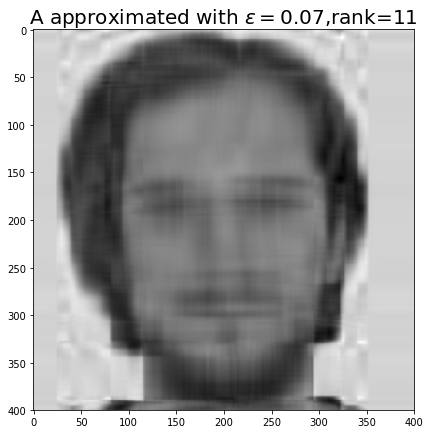

In [220]:

f,ax = plt.subplots(figsize=(7,7))
plt.title(r'A approximated with $\epsilon=$'+str(eps)+',rank='+str(rank), fontsize=20)
plt.imshow(img_appr, cmap=plt.cm.gray)

### Part B (10 pts)

1. Plot singular values for Ivan images **B** and **C** in one figure. Again, do not forget to use logarithmic scale! <br>

2. Derive analytically ranks of **B** and **C** from the rank of **A**.

In [199]:
(_,singB,_)=np.linalg.svd(img_diag_block)#B
(_,singC,_)=np.linalg.svd(img_block)#C

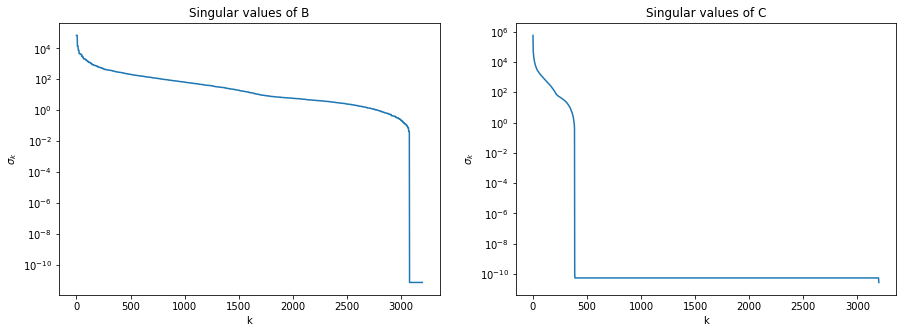

In [201]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.set_title('Singular values of B')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\sigma_k$')
ax1.set_yscale('log')
BPlot, = ax1.plot(singB)


#ax.legend([BPlot, CPlot], [r'$\sigma_k(B)$', r'$\sigma_k(C)$'])

ax2.set_title('Singular values of C')
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\sigma_k$')
ax2.set_yscale('log')
CPlot, = ax2.plot(singC)


It is seen that the singular values are approximately the same, however there more of them between the singular values of $A$.

We could calculate $\text{rank}(B)=d\text{rank}(A)$, where $d$ is a number of blocks since two groups of linearly independent(in block) vectors form a linearily independent set.

As to $C$, $\text{rank}(C)=\text{rank}(A)$ because the group of rows is linearily independent iff it is independent in the block.

This is what we see on the pictures above. Rank of $A$ is approximately $340$, according to its plot of singular values, there are $8$ blocks in $B$, so the rank of $B$ is about $3100$.

## Problem 5 (Bonus)

1. The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.

2. Write a function ```ranks_HOSVD(A, eps)```
that calculates Tucker ranks of a d-dimensional tensor $A$ using High-Order SVD (HOSVD) algorithm, where ```eps``` is the relative accuracy in the Frobenius norm between the approximated and the initial tensors. Details can be found [here](http://ca.sandia.gov/~tgkolda/pubs/pubfiles/TensorReview.pdf) on Figure 4.3.
```python
def ranks_HOSVD(A, eps):
      return r #r should be a tuple of ranks r = (r1, r2, ..., rd)
```
3. Find Hessian of  $f(x_1,\dots,x_n) = \log \left( \displaystyle{\sum_{i=1}^n} e^{x_i} \right)$ and check if it is positive definite.

### 1
Consider the operator $2$-norm in the space of $2 \times 2$ complex matrices. Let 
$$A = \left[\begin{array}
{rr}
1+i & 2  \\
1 & 1  
\end{array}\right], \vert A \vert = \left[\begin{array}
{rr}
\sqrt{2} & 2  \\
1 & 1  
\end{array}\right]
$$

In [216]:
(_,sings1,_)=np.linalg.svd(np.matrix([[1+1j,2],[1,1j]]))
(_,sings2,_)=np.linalg.svd(np.matrix([[np.sqrt(2),2],[1,1]]))


In [217]:
print(sings1,sings2)

[ 2.53958456  1.24519487] [ 2.8207932   0.20766727]


So we see that the norm $\Vert A \Vert = \sqrt{\vert\sigma_1(A)\vert^2} \neq \Vert ~\vert A\vert ~\Vert$

### 3

To obtain Hessian matrix we need to compute partial derivatives
$$
\frac{\partial^2 f}{\partial x_i \partial x_j}=\frac{\partial}{\partial x_j}\left[ \frac{1}{\sum_{k=1}^ne^{x_i}}e^{x_i}\right]=-\frac{\text{exp}(x_i+x_j)}{\left(\sum_{k=1}^n \text{exp}(x_i) \right)^2}.
$$
The Hessian matrix is the matrix consisting of these derivatives, so

$$
H_f(x)=-\frac{1}{\left(\sum_{k=1}^n \text{exp}(x_i) \right)^2} \left(\text{exp}(x_i+x_j)\right)_{ij}.
$$